In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
from google.colab import files
uploaded = files.upload()

Saving raw.txt to raw.txt



First 5 rows of data:
   user activity       timestamp         x          y         z
0    33  Jogging  49105962326000 -0.694638  12.680544  0.503953
1    33  Jogging  49106062271000  5.012288  11.264028  0.953424
2    33  Jogging  49106112167000  4.903325  10.882658 -0.081722
3    33  Jogging  49106222305000 -0.612916  18.496431  3.023717
4    33  Jogging  49106332290000 -1.184970  12.108489  7.205164

Dataset Information:
Number of examples: 1086475
Number of attributes: 6

Missing values:
user         0
activity     0
timestamp    0
x            0
y            0
z            0
dtype: int64

Class Distribution:
Walking: 418395 (38.5%)
Jogging: 336450 (31.0%)
Upstairs: 122869 (11.3%)
Downstairs: 100427 (9.2%)
Sitting: 59939 (5.5%)
Standing: 48395 (4.5%)


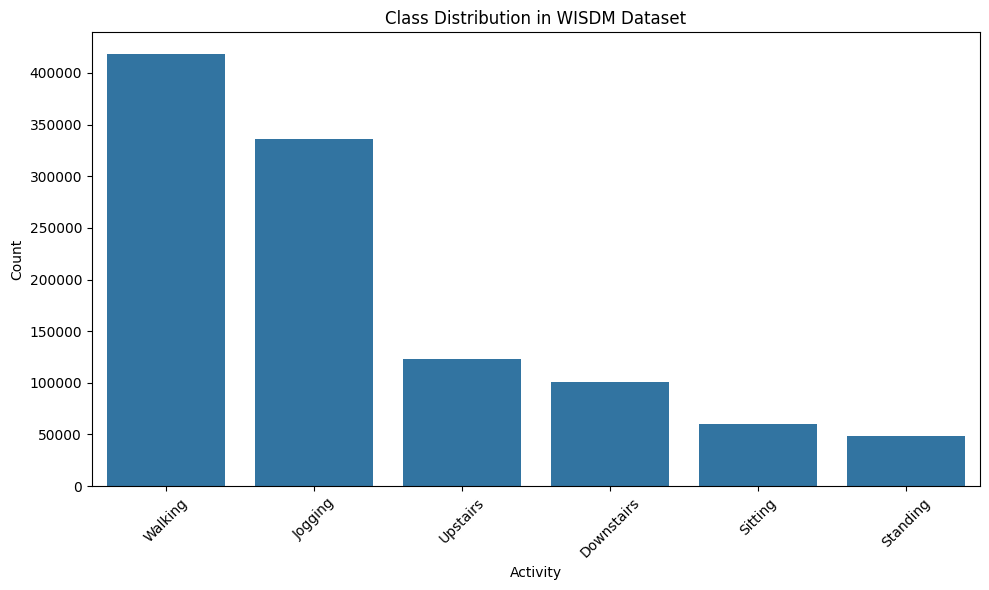

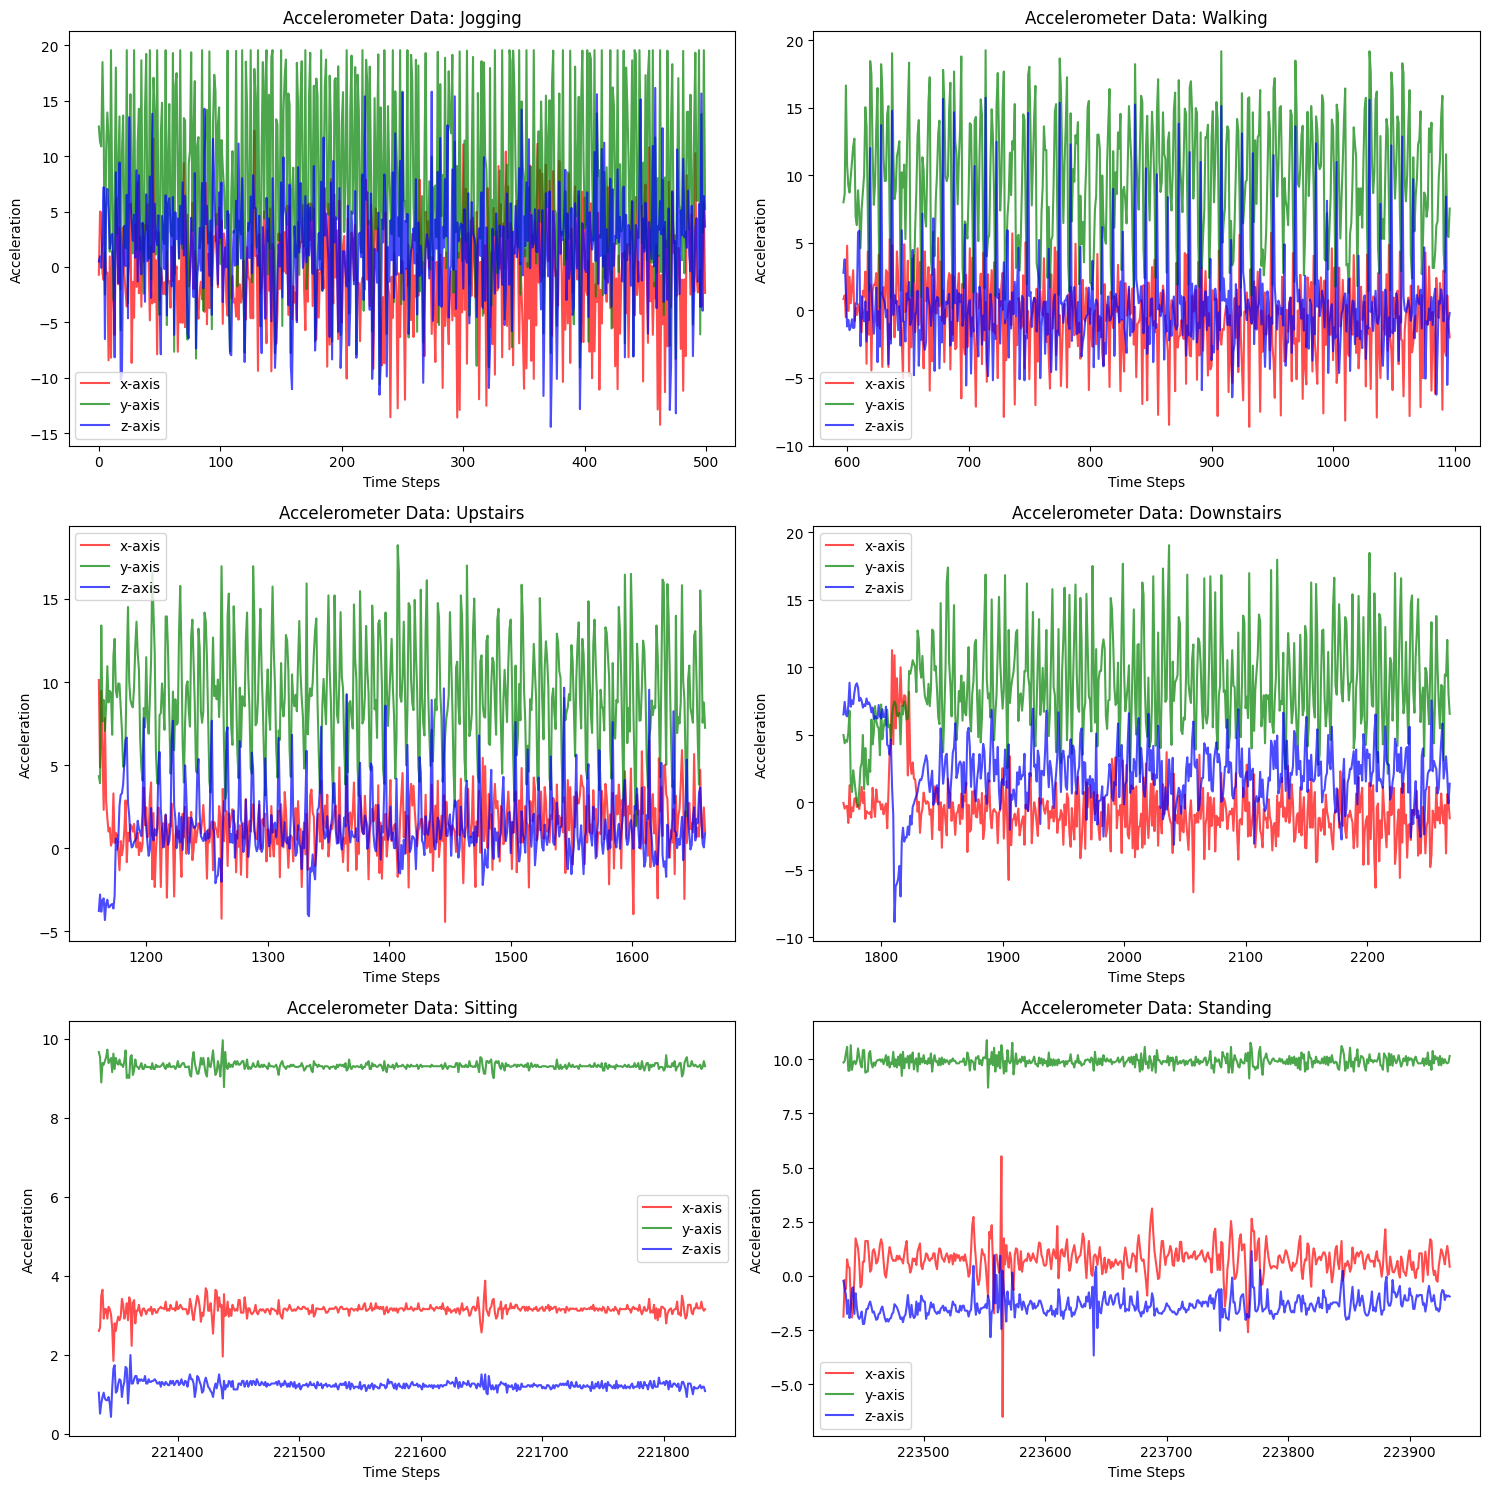

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Load the entire file as one big string
with open("raw.txt", "r") as file:
    content = file.read()

# Use regex to extract valid records
pattern = r"(\d+),(\w+),(\d+),([-.\d]+),([-.\d]+),([-.\d]+);"
matches = re.findall(pattern, content)

# Convert to DataFrame
data = pd.DataFrame(matches, columns=['user', 'activity', 'timestamp', 'x', 'y', 'z'])

# Convert numeric columns
data['user'] = data['user'].astype(int)
data['timestamp'] = data['timestamp'].astype(int)
data['x'] = data['x'].astype(float)
data['y'] = data['y'].astype(float)
data['z'] = data['z'].astype(float)

# Display the first few rows
print("\nFirst 5 rows of data:")
print(data.head())

# Check dataset info
print("\nDataset Information:")
print(f"Number of examples: {len(data)}")
print(f"Number of attributes: {len(data.columns)}")

# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing values:")
print(missing_values)

# Display class distribution
print("\nClass Distribution:")
class_distribution = data['activity'].value_counts()
for activity, count in class_distribution.items():
    percentage = (count / len(data)) * 100
    print(f"{activity}: {count} ({percentage:.1f}%)")

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title('Class Distribution in WISDM Dataset')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize accelerometer data for each activity
plt.figure(figsize=(15, 15))  # Increase figure size for better layout
activities = data['activity'].unique()

# Plot the accelerometer data for each activity (up to 6 activities)
for i, activity in enumerate(activities[:min(6, len(activities))]):
    plt.subplot(3, 2, i+1)  # 3 rows, 2 columns for subplot layout
    activity_data = data[data['activity'] == activity].iloc[:500]  # Take first 500 samples

    # Plot x, y, z axis data
    plt.plot(activity_data['x'], label='x-axis', color='r', alpha=0.7)
    plt.plot(activity_data['y'], label='y-axis', color='g', alpha=0.7)
    plt.plot(activity_data['z'], label='z-axis', color='b', alpha=0.7)

    # Title and labels
    plt.title(f'Accelerometer Data: {activity}')
    plt.xlabel('Time Steps')
    plt.ylabel('Acceleration')
    plt.legend(loc='best')

    # Tighten layout for each subplot
    plt.tight_layout()

# Show the plots
plt.show()


In [12]:
# Clean the data
data = data.dropna()  # Remove rows with missing values

# Encode activity labels
label_encoder = LabelEncoder()
data['activity_encoded'] = label_encoder.fit_transform(data['activity'])

# Display the label mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Activity label mapping:")
for activity, code in label_mapping.items():
    print(f"{activity}: {code}")

# Create segments using sliding windows
def create_segments(data, window_size=80, overlap=0.5):
    """
    Segment the accelerometer data into windows for sequence classification.

    Args:
        data: DataFrame containing the accelerometer data
        window_size: Number of time steps in each segment
        overlap: Percentage of overlap between consecutive windows

    Returns:
        X: Segmented accelerometer data
        y: Corresponding activity labels
    """
    segments = []
    labels = []

    print("Creating segments from accelerometer data...")
    # Group by user and activity to maintain context
    for (user, activity), group in data.groupby(['user', 'activity']):
        # Get encoded activity
        activity_encoded = label_encoder.transform([activity])[0]

        # Get accelerometer data
        x_data = group['x'].values
        y_data = group['y'].values
        z_data = group['z'].values

        # Calculate step size for overlapping windows
        step = int(window_size * (1 - overlap))

        # Create windows/segments
        for i in range(0, len(x_data) - window_size, step):
            xs = x_data[i:i+window_size]
            ys = y_data[i:i+window_size]
            zs = z_data[i:i+window_size]

            # Stack the 3 accelerometer channels
            segment = np.dstack([xs, ys, zs])
            segments.append(segment)
            labels.append(activity_encoded)

    # Convert to numpy arrays
    X = np.array(segments)
    y = np.array(labels)

    # Reshape to match model input requirements (samples, time steps, features)
    X = X.reshape(X.shape[0], window_size, 3)

    # One-hot encode the labels
    y = to_categorical(y)

    print(f"Created {len(segments)} segments")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")

    return X, y

# Create segments with window size of 80 and 50% overlap
window_size = 80
X, y = create_segments(data, window_size=window_size, overlap=0.5)

# Split data into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Activity label mapping:
Downstairs: 0
Jogging: 1
Sitting: 2
Standing: 3
Upstairs: 4
Walking: 5
Creating segments from accelerometer data...
Created 26889 segments
X shape: (26889, 80, 3)
y shape: (26889, 6)
Training set: (16133, 80, 3), (16133, 6)
Validation set: (5378, 80, 3), (5378, 6)
Test set: (5378, 80, 3), (5378, 6)


LSTM Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 80, 128)        │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,270 (465.90 KB)

 Trainable params: 119,270 (465.90 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM model...
Epoch 1/15
505/505 ━━━━━━━━━━━━━━━━━━━━ 75s 140ms/step - accuracy: 0.7076 - loss: 0.8602 - val_accuracy: 0.8312 - val_loss: 0.4640
Epoch 2/15
505/505 ━━━━━━━━━━━━━━━━━━━━ 87s 149ms/step - accuracy: 0.8399 - loss: 0.4275 - val_accuracy: 0.8981 - val_loss: 0.2908
Epoch 3/15
505/505 ━━━━━━━━━━━━━━━━━━━━ 82s 150ms/step - accuracy: 0.8892 - loss: 0.2879 - val_accuracy: 0.9212 - val_loss: 0.2114
Epoch 4/15
505/505 ━━━━━━━━━━━━━━━━━━━━ 82s 162ms/step - accuracy: 0.9250 - loss: 0.2061 - val_accuracy: 0.9195 - val_loss: 0.1905
Epoch 5/15
505/505 ━━━━━━━━━━━━━━━━━━━━ 75s 148ms/step - accuracy: 0.9451 - loss: 0.1659 - val_accuracy: 0.9373 - val_loss: 0.1630
Epoch 6/15
505/505 ━━━━━━━━━━━━━━━━━━━━ 82s 148ms/step - accuracy: 0.9584 - loss: 0.1161 - val_accuracy: 0.9591 - val_loss: 0.1209
Epoch 7/15
505/505 ━━━━━━━━━━━━━━━━━━━━ 82s 149ms/step - accuracy: 0.9685 - loss: 0.0928 - val_accuracy: 0.9613 - val_loss: 0.1259
Epoch 8/15
505/505 ━━━━━━━━━━━━━━━━━━━━ 81s 148ms/step - ac

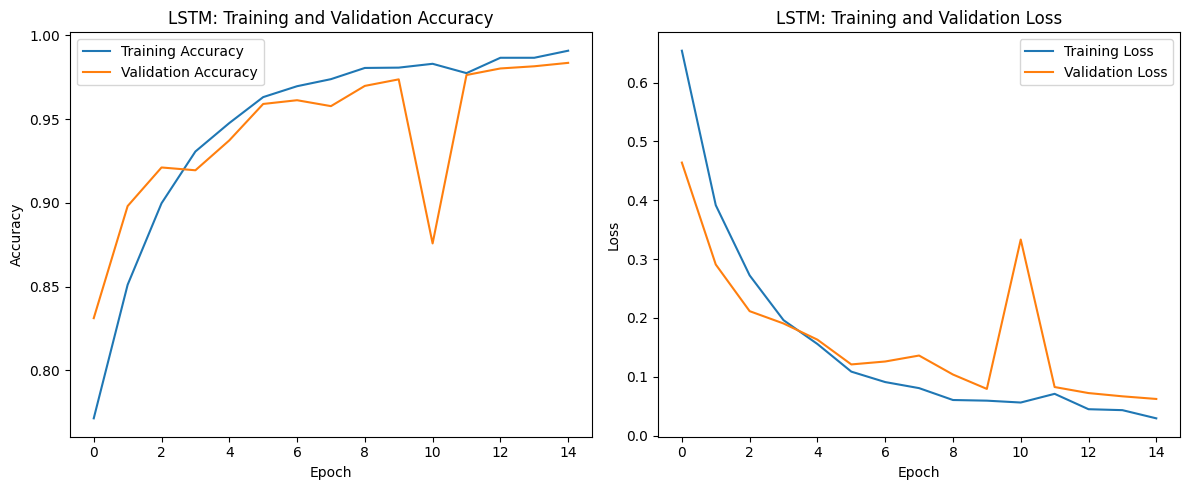


Evaluating LSTM model on test set...
LSTM Test Accuracy: 0.9842


In [13]:
# Build LSTM model for activity recognition
def build_lstm_model(input_shape, num_classes):
    """
    Build an LSTM-based model for human activity recognition.

    Args:
        input_shape: Shape of input data (time_steps, features)
        num_classes: Number of activity classes

    Returns:
        model: Compiled Keras model
    """
    model = Sequential([
        LSTM(128, input_shape=input_shape, return_sequences=True),
        Dropout(0.2),  # Add dropout to prevent overfitting
        LSTM(64, return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')  # Output layer with softmax
    ])

    # Compile the model
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    return model

# Build the LSTM model
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, features)
num_classes = y_train.shape[1]  # Number of activity classes

lstm_model = build_lstm_model(input_shape, num_classes)
print("LSTM Model Summary:")
lstm_model.summary()

# Define callbacks for training
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,  # Stop if no improvement for 5 epochs
    restore_best_weights=True  # Restore weights from best epoch
)

# Train the LSTM model
print("\nTraining LSTM model...")
history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=15,  # Maximum number of epochs
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('LSTM: Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM: Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the LSTM model on the test set
print("\nEvaluating LSTM model on test set...")
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Test Accuracy: {lstm_accuracy:.4f}")

CNN Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 78, 64)         │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 39, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 39, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 37, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,030 (1.26 MB)

 Trainable params: 329,030 (1.26 MB)

 Non-trainable params: 0 (0.00 B)


Training CNN model...
Epoch 1/15
505/505 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.7210 - loss: 0.8081 - val_accuracy: 0.8393 - val_loss: 0.3815
Epoch 2/15
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8760 - loss: 0.3264 - val_accuracy: 0.9158 - val_loss: 0.2290
Epoch 3/15
505/505 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9226 - loss: 0.2162 - val_accuracy: 0.9403 - val_loss: 0.1754
Epoch 4/15
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9435 - loss: 0.1500 - val_accuracy: 0.9431 - val_loss: 0.1571
Epoch 5/15
505/505 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9567 - loss: 0.1244 - val_accuracy: 0.9440 - val_loss: 0.1515
Epoch 6/15
505/505 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9626 - loss: 0.1089 - val_accuracy: 0.9587 - val_loss: 0.1118
Epoch 7/15
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9688 - loss: 0.0857 - val_accuracy: 0.9636 - val_loss: 0.1056
Epoch 8/15
505/505 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9739

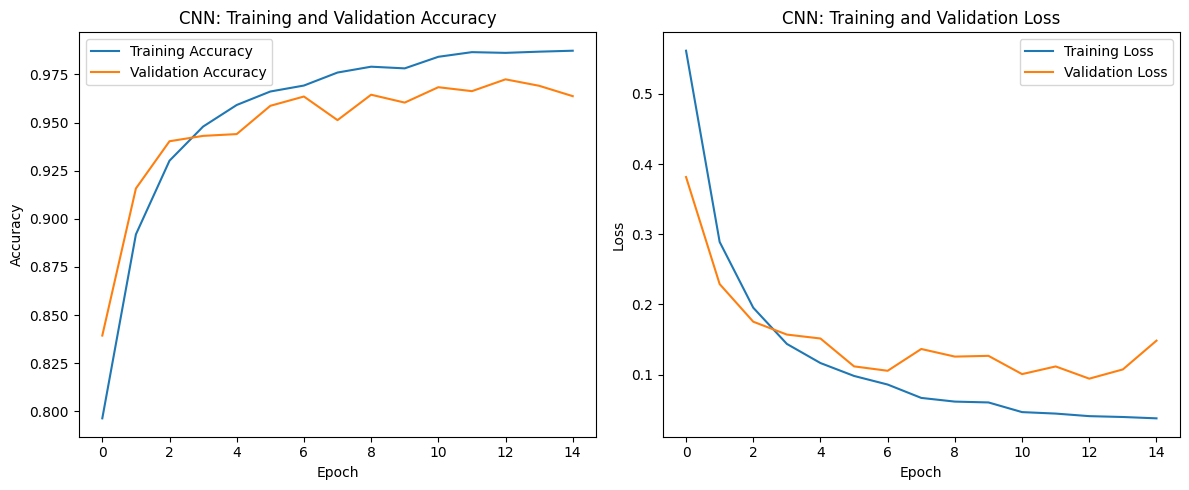


Evaluating CNN model on test set...
CNN Test Accuracy: 0.9742


In [15]:
# Build CNN model for activity recognition
def build_cnn_model(input_shape, num_classes):
    """
    Build a 1D CNN model for human activity recognition.

    Args:
        input_shape: Shape of input data (time_steps, features)
        num_classes: Number of activity classes

    Returns:
        model: Compiled Keras model
    """
    model = Sequential([
        # First convolutional layer
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),

        # Second convolutional layer
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),

        # Flatten and dense layers
        Flatten(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')  # Output layer with softmax
    ])

    # Compile the model
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    return model

# Build the CNN model
cnn_model = build_cnn_model(input_shape, num_classes)
print("CNN Model Summary:")
cnn_model.summary()

# Train the CNN model
print("\nTraining CNN model...")
history_cnn = cnn_model.fit(
    X_train, y_train,
    epochs=15,  # Maximum number of epochs
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],  # Use the same early stopping callback
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN: Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN: Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the CNN model on the test set
print("\nEvaluating CNN model on test set...")
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test, verbose=0)
print(f"CNN Test Accuracy: {cnn_accuracy:.4f}")


--- Detailed Model Evaluation ---
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step
LSTM Test Accuracy: 0.9842

LSTM Classification Report:
              precision    recall  f1-score   support

  Downstairs       0.96      0.95      0.95       493
     Jogging       0.99      0.99      0.99      1672
     Sitting       1.00      0.95      0.97       293
    Standing       0.95      1.00      0.97       234
    Upstairs       0.97      0.96      0.96       605
     Walking       0.99      1.00      0.99      2081

    accuracy                           0.98      5378
   macro avg       0.98      0.97      0.97      5378
weighted avg       0.98      0.98      0.98      5378



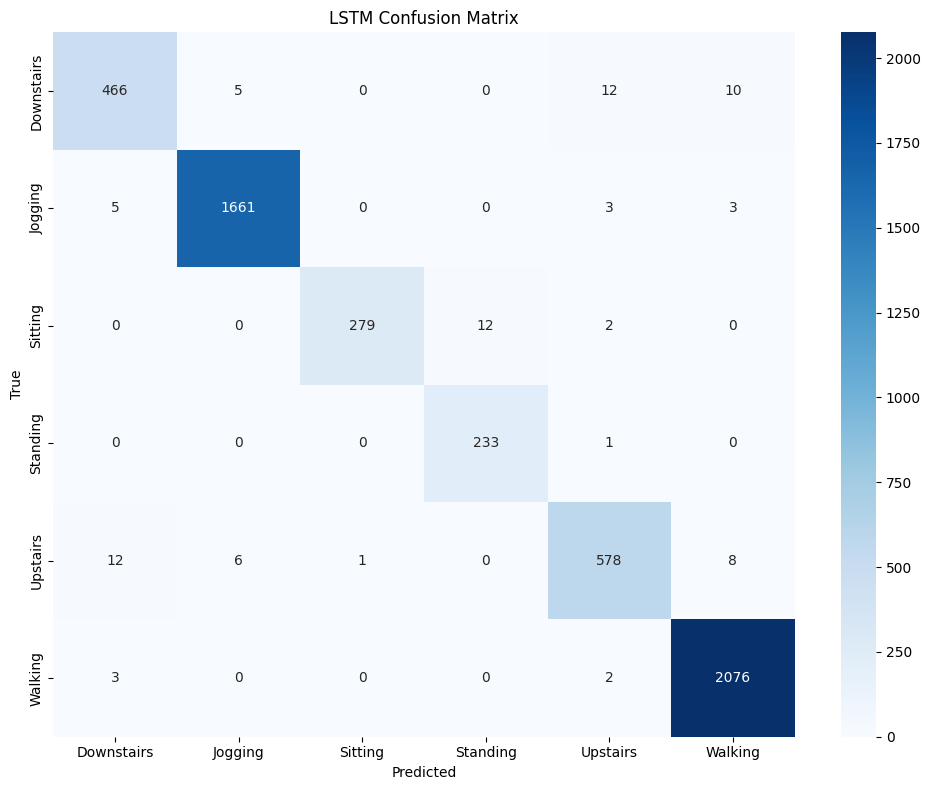

169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
CNN Test Accuracy: 0.9742

CNN Classification Report:
              precision    recall  f1-score   support

  Downstairs       0.95      0.90      0.92       493
     Jogging       0.99      0.99      0.99      1672
     Sitting       1.00      0.96      0.98       293
    Standing       0.96      1.00      0.98       234
    Upstairs       0.91      0.93      0.92       605
     Walking       0.99      0.99      0.99      2081

    accuracy                           0.97      5378
   macro avg       0.96      0.96      0.96      5378
weighted avg       0.97      0.97      0.97      5378



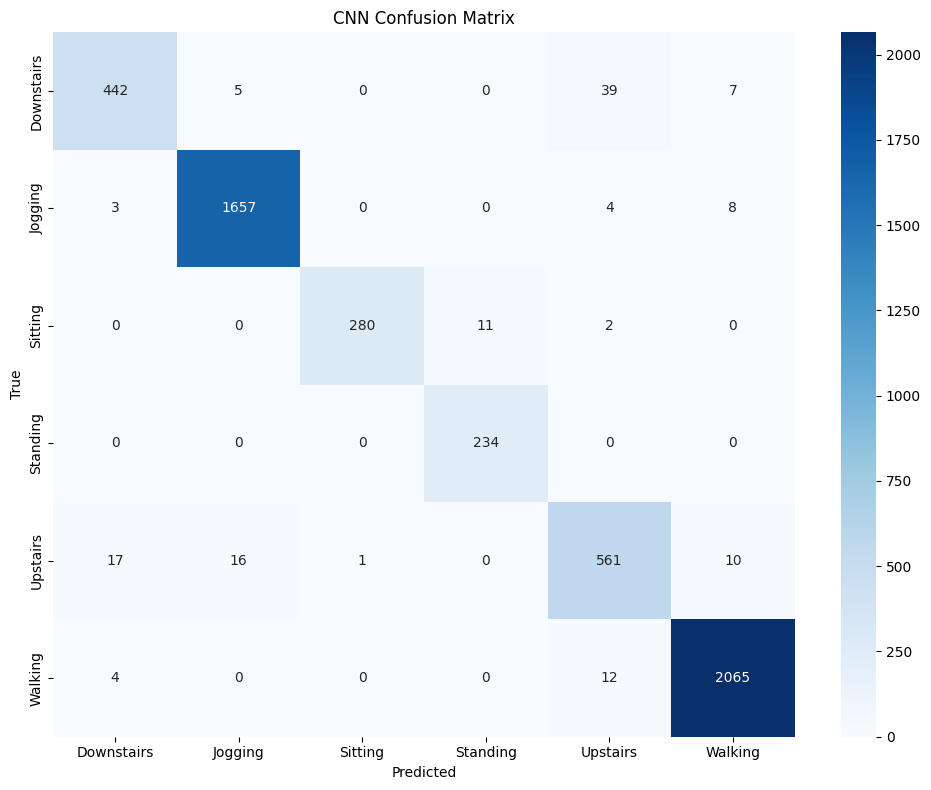


--- Model Comparison ---
LSTM Model Accuracy: 0.9842
CNN Model Accuracy: 0.9742

The LSTM model performed better on this dataset!
LSTM model saved as 'wisdm_best_model.h5'

You can now use the saved model to make predictions on new data!


In [16]:
# Function to evaluate models in detail
def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluate a model and display detailed metrics.

    Args:
        model: Trained model
        X_test: Test data
        y_test: Test labels
        model_name: Name of the model for display
    """
    # Get predictions
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"{model_name} Test Accuracy: {accuracy:.4f}")

    # Generate classification report
    print(f"\n{model_name} Classification Report:")
    class_names = label_encoder.classes_
    report = classification_report(y_true, y_pred, target_names=class_names)
    print(report)

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} Confusion Matrix')
    plt.tight_layout()
    plt.show()

    return accuracy, report

# Evaluate both models
print("\n--- Detailed Model Evaluation ---")
lstm_accuracy, lstm_report = evaluate_model(lstm_model, X_test, y_test, "LSTM")
cnn_accuracy, cnn_report = evaluate_model(cnn_model, X_test, y_test, "CNN")

# Compare the models
print("\n--- Model Comparison ---")
print(f"LSTM Model Accuracy: {lstm_accuracy:.4f}")
print(f"CNN Model Accuracy: {cnn_accuracy:.4f}")

# Determine the better model
better_model = "LSTM" if lstm_accuracy >= cnn_accuracy else "CNN"
print(f"\nThe {better_model} model performed better on this dataset!")

# Save the better model
if better_model == "LSTM":
    lstm_model.save('wisdm_best_model.h5')
    print("LSTM model saved as 'wisdm_best_model.h5'")
else:
    cnn_model.save('wisdm_best_model.h5')
    print("CNN model saved as 'wisdm_best_model.h5'")

# Sample prediction function for new data
def predict_activity(model, new_data, window_size=80):
    """
    Make predictions on new accelerometer data.

    Args:
        model: Trained model
        new_data: New accelerometer data (should be preprocessed similarly)
        window_size: Size of the window used during training

    Returns:
        Predicted activity labels
    """
    # Preprocess new data (assuming it's already segmented)
    # new_data should have shape (samples, window_size, 3)

    # Make predictions
    predictions = model.predict(new_data)
    predicted_classes = np.argmax(predictions, axis=1)

    # Convert numeric classes to activity labels
    predicted_labels = label_encoder.inverse_transform(predicted_classes)

    return predicted_labels

print("\nYou can now use the saved model to make predictions on new data!")

In [19]:
# Example of how to use the trained model

# First, let's create a function to simulate new data
def simulate_new_data(data, num_samples=5):
    """
    Simulate new accelerometer data by randomly sampling from the test set.

    Args:
        data: Original DataFrame containing accelerometer data
        num_samples: Number of samples to generate

    Returns:
        Simulated data segments ready for prediction
    """
    print(f"Simulating {num_samples} new accelerometer data samples...")

    # Randomly sample from the original data
    random_indices = np.random.choice(len(X_test), num_samples, replace=False)
    simulated_data = X_test[random_indices]
    true_labels = np.argmax(y_test[random_indices], axis=1)

    return simulated_data, true_labels

# Load the best model (alternatively, you can use the models already in memory)
try:
    best_model = tf.keras.models.load_model('wisdm_best_model.h5')
    print("Loaded saved model 'wisdm_best_model.h5'")
except:
    # If the model hasn't been saved yet, use the better model from memory
    if lstm_accuracy >= cnn_accuracy:
        best_model = lstm_model
        print("Using LSTM model from memory")
    else:
        best_model = cnn_model
        print("Using CNN model from memory")

# Simulate new data
new_data, true_labels = simulate_new_data(data, num_samples=10)

# Make predictions
predictions = best_model.predict(new_data)
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_classes)
true_activity_labels = label_encoder.inverse_transform(true_labels)

# Display the predictions
print("\nPrediction Results:")
print("------------------------------------")
print("Sample | True Activity | Predicted Activity | Confidence")
print("------------------------------------")

for i in range(len(predicted_labels)):
    confidence = np.max(predictions[i]) * 100
    print(f"{i+1:6d} | {true_activity_labels[i]:12s} | {predicted_labels[i]:17s} | {confidence:.2f}%")

# Function to process new accelerometer data in real time
def process_real_time_data(x_values, y_values, z_values, window_size=80):
    """
    Process real-time accelerometer data for prediction.

    Args:
        x_values: List of x-axis accelerometer values
        y_values: List of y-axis accelerometer values
        z_values: List of z-axis accelerometer values
        window_size: Size of window used for training

    Returns:
        Processed data ready for prediction
    """
    # Ensure we have enough data points
    if len(x_values) < window_size:
        print(f"Not enough data points. Need {window_size}, but got {len(x_values)}")
        return None

    # Use the most recent window_size points
    x_window = x_values[-window_size:]
    y_window = y_values[-window_size:]
    z_window = z_values[-window_size:]

    # Create the segment
    segment = np.dstack([x_window, y_window, z_window])

    # Reshape to match model input requirements
    processed_data = segment.reshape(1, window_size, 3)

    return processed_data

# Example of how this function would be used
print("\nExample of real-time prediction (simulated):")
print("-------------------------------------------")

# Simulate streaming data (using a sample from our dataset)
sample_idx = np.random.choice(len(data))
sample_activity = data.iloc[sample_idx]['activity']
sample_user = data.iloc[sample_idx]['user']

# Get 100 consecutive accelerometer readings
start_idx = sample_idx
end_idx = min(start_idx + 100, len(data))
stream_data = data.iloc[start_idx:end_idx]

# Initialize empty lists for accelerometer values
x_values = []
y_values = []
z_values = []

# Simulate streaming data coming in
print(f"Simulating real-time data for User {sample_user} doing {sample_activity}...")
for i, row in stream_data.iterrows():
    # Add new values
    x_values.append(row['x'])
    y_values.append(row['y'])
    z_values.append(row['z'])

    # Once we have enough data, make a prediction
    if len(x_values) >= window_size:
        # Process the data
        processed_data = process_real_time_data(x_values, y_values, z_values, window_size)

        # Make a prediction
        if processed_data is not None:
            pred = best_model.predict(processed_data, verbose=0)
            pred_class = np.argmax(pred[0])
            pred_label = label_encoder.inverse_transform([pred_class])[0]
            confidence = np.max(pred[0]) * 100

            # Display the result
            print(f"Current activity: {pred_label} (Confidence: {confidence:.2f}%)")

            # For simulation purposes, only do this once
            break


Loaded saved model 'wisdm_best_model.h5'
Simulating 10 new accelerometer data samples...


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step

Prediction Results:
------------------------------------
Sample | True Activity | Predicted Activity | Confidence
------------------------------------
     1 | Walking      | Walking           | 100.00%
     2 | Walking      | Walking           | 100.00%
     3 | Upstairs     | Upstairs          | 99.82%
     4 | Jogging      | Jogging           | 99.99%
     5 | Sitting      | Sitting           | 100.00%
     6 | Downstairs   | Downstairs        | 99.85%
     7 | Jogging      | Jogging           | 99.98%
     8 | Downstairs   | Downstairs        | 99.81%
     9 | Upstairs     | Upstairs          | 53.88%
    10 | Walking      | Walking           | 100.00%

Example of real-time prediction (simulated):
-------------------------------------------
Simulating real-time data for User 9 doing Walking...
Current activity: Walking (Confidence: 100.00%)


In [21]:
lstm_history = lstm_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=1)
cnn_history = cnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=1)


Epoch 1/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 73s 144ms/step - accuracy: 0.9900 - loss: 0.0314 - val_accuracy: 0.9790 - val_loss: 0.0887
Epoch 2/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 83s 145ms/step - accuracy: 0.9949 - loss: 0.0205 - val_accuracy: 0.9788 - val_loss: 0.0771
Epoch 3/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 79s 140ms/step - accuracy: 0.9876 - loss: 0.0386 - val_accuracy: 0.9851 - val_loss: 0.0515
Epoch 4/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 84s 144ms/step - accuracy: 0.9898 - loss: 0.0343 - val_accuracy: 0.9868 - val_loss: 0.0514
Epoch 5/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 86s 152ms/step - accuracy: 0.9923 - loss: 0.0253 - val_accuracy: 0.9784 - val_loss: 0.0784
Epoch 6/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 74s 135ms/step - accuracy: 0.9935 - loss: 0.0218 - val_accuracy: 0.9812 - val_loss: 0.0658
Epoch 7/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 87s 145ms/step - accuracy: 0.9952 - loss: 0.0152 - val_accuracy: 0.9868 - val_loss: 0.0535
Epoch 8/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 82s 145ms/step - accuracy: 0.9949 - loss: 0

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['accuracy'], label='LSTM Train', color='blue')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Val', linestyle='--', color='blue')
plt.plot(cnn_history.history['accuracy'], label='CNN Train', color='green')
plt.plot(cnn_history.history['val_accuracy'], label='CNN Val', linestyle='--', color='green')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'], label='LSTM Train', color='blue')
plt.plot(lstm_history.history['val_loss'], label='LSTM Val', linestyle='--', color='blue')
plt.plot(cnn_history.history['loss'], label='CNN Train', color='green')
plt.plot(cnn_history.history['val_loss'], label='CNN Val', linestyle='--', color='green')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
